
# Artifact Evaluation

> #### Optimizing Deep Learning Inference via Global Analysis and Tensor Expressions

Optimizing deep neural network (DNN) execution is impor- tant but becomes increasingly difficult as DNN complexity grows. Existing DNN compilers cannot effectively exploit op- timization opportunities across operator boundaries, leaving room for improvement. To address this challenge, we present Souffle, an open-source compiler that optimizes DNN in- ference across operator boundaries. Souffle creates a global tensor dependency graph using tensor expressions, traces data flow and tensor information, and partitions the compu- tation graph into subprograms based on dataflow analysis and resource constraints. Within a subprogram, Souffle per- forms local optimization via semantic-preserving transfor- mations, finds an optimized program schedule, and improves instruction-level parallelism and data reuse. We evaluated Souffle using six representative DNN models on an NVIDIA A100 GPU. Experimental results show that Souffle consis- tently outperforms six state-of-the-art DNN optimizers by 
delivering a geometric mean speedup of up to $3.7\times$ over TensorRT and $7.8\times$ over Tensorflow XLA.

## Preliminaries
This repository showcases the performance evaluation and comparison between `Souffle`(Our work) and the existing state-of-the-art compilers/frameworks(including `XLA`, `TensorRT`, `Rammer`, `Apollo` and `IREE`).

- **XLA(Tensorflow v2.10)**: The TensorFlow XLA compiler
can fuse DNN operators like point-wise and reduction op-
erators and performs optimizations on the fused operator.
Unlike Souffle that performs analysis and optimizations on
TEs, XLA performs analysis on its high-level operators(HLO)

- **TensorRT(v8.2)**:This GPU-vendor-specific framework optimizes the inference of DNNs on NVIDIA GPUs

- **Rammer(v0.4)**:This DNN compiler is also known as NNFu-
sion. It generates a spatial-temporal schedule at compile
time to minimize scheduling overhead and exploit hardware
parallelism through inter- and intra-operator co-scheduling

- **Apollo**:This represents the state-of-the-art fusion framework for inference optimization. Apollo considers both
memory- and compute-bound tensor operators for kernel
fusions and uses hand-crafted rules to exploit parallelism
between independent tensor operators

- **IREE**:The intermediate resentation execution environment (IREE) builds upon the
LLVM MLIR project. IREE is designed to lower DNN
models to MLIR dialects to optimize model inference. IREE
utilizes the linalg dialect to perform the operator fusion,
which supports loop affine fusion optimization and global
analysis.

The metric assesed in this notebook mainly include end-to-end latency, global memory access and number of kernels.

## Important Notes
**A few bash scripts take more than half an hour to complete; Please wait for the results before executing the next one.**
**I will also provide a online jupyter notebook if you are inconvenient or having troubles  to build the environment. The jupyter notebook is run on our server and you can directly access the notebook and run the experiments from the internet**
### Links to The Paper

**For each step, we highlight that the current evaluation is corresponding to which Section or Figure in the submitted paper.**
The main restuls presented in this repository correspond to the submitted paper's Table 3, 4, 5 and Figure 6.


## 1. Experimental Environments Setup

We have setup the experiment environments on our machine.
For more info about how to setup on you local machine, please refer to `README.md`

### Check the status of docker containers

In [1]:
!docker ps

CONTAINER ID   IMAGE                                      COMMAND                  CREATED          STATUS          PORTS                                                                 NAMES
f3092dae92cb   souffle-tensorrt8.4.1-ubuntu18.04:latest   "/opt/nvidia/nvidia_…"   25 seconds ago   Up 24 seconds                                                                         kind_wescoff
063901f1ed47   souffle-iree:latest                        "/opt/nvidia/nvidia_…"   6 hours ago      Up 4 minutes    6006/tcp, 8888/tcp                                                    cranky_dewdney
40e065f9c549   sunqianqi/sirius:mlsys_ae                  "/bin/bash"              26 hours ago     Up 4 minutes                                                                          souffle-rammer
8522912851b0   souffle-tvm-0.8:latest                     "/opt/nvidia/nvidia_…"   43 hours ago     Up 4 minutes                                                                          interesting_buck
f4a7

You should see containers with the following image names:
* souffle-tvm-0.8:latest
* souffle-iree:latest
* souffle-tensorrt8.4.1-ubuntu18.04:latest

### Check the hardware of the server (nvidia A100 GPU)

In [3]:
!nvidia-smi

Fri Dec 29 08:31:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A800-SXM4-80GB          Off | 00000000:3D:00.0 Off |                    0 |
| N/A   36C    P0              56W / 400W |      5MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## 2. Evaluation
Next, we use four cases to test the end-to-end performance for the baseline compilers and our work.
Each case matches a table or figure in the submitted paper.

we recommend you to run these cases one by one, which reduces the total execution time at most **two hours**.
We also provided a fast mode which re-use the existing profiling data 
to directly print the outputs.

- 2.1 CASE - End-to-end model runtime (Table 3 in Section 8) - around 30 minutes.
- 2.2 CASE - Execution time with Souffle individual optimization (Table 4 in Section 8) - around 30 minutes.
- 2.3 CASE - The number of GPU kernel calls and global memory
data transfer size of the resulting code (Table 5 in Section 8) - around 50 minutes.
- 2.4 CASE - EfficientNet sub-module latency breakdown (Figure 6 in Section 8) - around 10 minutes.

**Log files**

PS: some cases would consume over a half-hour because we have to execute all baselines. Please have a coffee and wait for the output before the subsequent execution.

### 2.1 CASE - End-to-end model runtime (Table 3)
In this case, we compare souffle with five representative state-of-the-art baselines to exploit the end-to-end latency.
We omit Ansor in this case.

| Model       | XLA  | TRT   | Rammer | Apollo | IREE  | Ours |
| ----        | ---- | ----  | ----   | ----   | ----  | ---- |
| BERT        | 2.55 | 1.30  | 2.19   | 3.29   | 2.22  | 1.22 |
| ResNeXt     | 8.91 | 24.82 | 11.69  | 22.80  | 314.8 | 4.43 |
| LSTM        | 10.57| 6.30  | 1.72   | Failed | 16.0  | 0.80 |
| EfficientNet| 2.96 | 1.21  | Falied | 2.3    | 12.33 | 0.66 |
| SwinTrans.  | 6.43 | 1.74  | Falied | 10.78  | 18.1  | 1.55 |
| MMoE        | 0.29 | 0.07  | Falied | 0.049  | 0.088 | 0.014|

**The following commonds reproduce the results of Table 3 in the submiited paper. Please refer to Section8(Page 10) for more details**

Run the experiments:
Note, The args `TRUE` means that we run the workloads rather than read the cached profiling results.

In [4]:
!bash scripts/run_table3.sh TRUE

+++ dirname scripts/run_table3.sh
++ cd scripts
++ pwd
+ script_directory=/home/zhangshuoming/souffle-ae/scripts
+ SOUFFLE_RUN=TRUE
+ '[' -e /home/zhangshuoming/souffle-ae/scripts/../results/table3.csv ']'
+ rm -f /home/zhangshuoming/souffle-ae/scripts/../results/table3.csv
+ touch /home/zhangshuoming/souffle-ae/scripts/../results/table3.csv
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ '[' '!' 8522912851b0 ']'
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ souffle_container_id=8522912851b0
+ echo 8522912851b0
8522912851b0
+ docker exec -it -e SOUFFLE_RUN=TRUE 8522912851b0 /bin/bash -c /workspace/baseline/xla/run_xla.sh
++ cd /workspace/baseline/xla/xla_models
++ SOUFFLE_RUN=
++ export TF_DUMP_GRAPH_PREFIX=/tmp/tf_dump_graph/
++ TF_DUMP_GRAPH_PREFIX=/tmp/tf_dump_graph/
++ export 'TF_XLA_FLAGS=--tf_xla_enable_xla_devices --tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'
++ TF_XLA_FLAGS='--tf_xla_enable_xla_devices --tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'
++ NCU_ARGS='--metrics d

Check for the results:

In [5]:
!cat results/table3.csv

XLA:, 2.200, 124.612, 25.849, 31.563, 23.544, 0.033
TensorRT:, 2.170, 24.697, 8.276, 1.197, 2.192, 0.066
Rammer:, 2.058, 11.488, 15.367, failed, failed, failed
Apollo:, 6.007, 17.904, failed, 2.262, 14.070, 0.064
IREE:, 19.926, 293.285, 10.197, 5.816, 28.277, 0.041
Souffle:, 1.604, 5.874, 1.097, 0.866, 2.357, 0.028


Note that the results in `table3.csv` is a transposed matrix of table 3 in the submmited paper.
### 2.2 CASE - Execution time with Souffle individual optimization (Table 4)
In this case, we present an ablation study by enable the individual optimization one-by-one
to demonstrate the effectiveness of each optmization techniques.
It takes about one hour to reproduce the results.

Run the experiments:

In [21]:
!bash scripts/run_table4.sh TRUE

+++ dirname scripts/run_table4.sh
++ cd scripts
++ pwd
+ script_directory=/home/zhangshuoming/souffle-ae/scripts
+ SOUFFLE_RUN=TRUE
+ '[' -e /home/zhangshuoming/souffle-ae/scripts/../results/table4.csv ']'
+ rm -f /home/zhangshuoming/souffle-ae/scripts/../results/table4.csv
+ touch /home/zhangshuoming/souffle-ae/scripts/../results/table4.csv
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ '[' '!' 8522912851b0 ']'
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ souffle_container_id=8522912851b0
+ echo 8522912851b0
8522912851b0
+ souffle_model_path=/workspace/souffle-models/python/models/
+ docker exec -it -e SOUFFLE_RUN=TRUE 8522912851b0 /bin/bash -c 'cd /workspace/souffle-models/python/models//bert && ./run_ncu_bert.sh'
+ bert_layers=12
+ NCU_ARGS='--metrics dram__bytes_read,gpu__time_duration --clock-control none'
+ '[' -n TRUE ']'
+ '[' TRUE = TRUE ']'
+ ncu --metrics dram__bytes_read,gpu__time_duration --clock-control none -o ncu-souffle_bert_O0 -f python3 souffle_bert.py O0 1

Check for the results:

In [22]:
cat results/table4.csv

BERT:, 2.720, 1.822, 1.641, 1.563, 1.574
RESNEXT:, 39.910, 8.170, 5.802, 5.802, 5.802
LSTM:, 11.776, 1.885, 1.562, 1.093, 1.093
EfficientNet:, 2.237, 2.231, 1.396, 0.911, 0.885
SwinTrans:, 6.972, 5.457, 2.206, 3.036, 2.206
MMoE:, 0.059, 0.031, 0.028, 0.019, 0.019


### 2.3 CASE - The number of GPU kernel calls and global memory data transfer size of the resulting code (Table 5)
In this case, We compare Souffle with STOA works about the number of GPU kernel calls and global memory data transfer size (M bytes).
Less number of GPU kernel calls and global memory data transfer size leads to better
fusion results.

Run the experiments:

In [7]:
!bash scripts/run_table5.sh TRUE

+++ dirname scripts/run_table5.sh
++ cd scripts
++ pwd
+ script_directory=/home/zhangshuoming/souffle-ae/scripts
+ SOUFFLE_RUN=TRUE
+ table5_path=/home/zhangshuoming/souffle-ae/scripts/../results/table5.csv
+ '[' -e /home/zhangshuoming/souffle-ae/scripts/../results/table5.csv ']'
+ rm -f /home/zhangshuoming/souffle-ae/scripts/../results/table5.csv
+ touch /home/zhangshuoming/souffle-ae/scripts/../results/table5.csv
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ '[' '!' 8522912851b0 ']'
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ souffle_container_id=8522912851b0
+ echo 'Souffle docker running: ' 8522912851b0
Souffle docker running:  8522912851b0
++ docker ps -qf ancestor=souffle-tensorrt8.4.1-ubuntu18.04:latest
+ '[' '!' 4bcfc2840118 ']'
++ docker ps -qf ancestor=souffle-tensorrt8.4.1-ubuntu18.04:latest
+ tensorrt_container_id=4bcfc2840118
+ echo 'TensorRT docker running:'
TensorRT docker running:
+ docker exec -it -e SOUFFLE_RUN=TRUE 4bcfc2840118 /bin/bash -c 'cd /workspace

Check for the results:

In [8]:
!cat results/table5.csv

TensorRT number of kernels:, 156, 2421, 1942, 180, 284, 21
TensorRT: memory read (MBytes):, 753.7766418457031, 753.1748046875, 1101.1689453125, 98.46963500976562, 664.0660400390625, 0.1262499988079071
Apollo number of kernels:, 317, 2551, Failed, 314, 1007, 12
Apollo memory read:, 931.0371704101562, 539.725341796875, Failed, 167.39404296875, 1209.347900390625, 0.13850000500679016
XLA number of kernels:, 240, 1089, 3365, 598, 3214, 9
Souffle number of kernels:, 24, 109, 1, 66, 226, 1
Souffle memory read:, 229.3125, 471.1038818359375, 21.12384033203125, 71.2207260131836, 307.4915771484375, 0.13862499594688416


### Only get xla number of kernels

In [ ]:
!docker exec -it -e SOUFFLE_RUN=TRUE $(docker ps -qf "ancestor=souffle-tvm-0.8:latest") /bin/bash -c "cd /workspace/baseline/xla && ./run_ncu_xla.sh"
!docker exec -it -e SOUFFLE_RUN=TRUE $(docker ps -qf "ancestor=souffle-tvm-0.8:latest") /bin/bash -c "cat /workspace/baseline/xla/xla_models/table5_xla.csv" >> results/table5.csv
!cat results/table5.csv

## 2.4 CASE - EfficientNet sub-module latency breakdown (Figure 6)
Run the experiments:

In [26]:
!bash scripts/run_figure6.sh TRUE

+++ dirname scripts/run_figure6.sh
++ cd scripts
++ pwd
+ script_directory=/home/zhangshuoming/souffle-ae/scripts
+ SOUFFLE_RUN=TRUE
+ '[' -e /home/zhangshuoming/souffle-ae/scripts/../results/table3.csv ']'
+ rm -f /home/zhangshuoming/souffle-ae/scripts/../results/table3.csv
+ touch /home/zhangshuoming/souffle-ae/scripts/../results/table3.csv
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ '[' '!' 8522912851b0 ']'
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ souffle_container_id=8522912851b0
+ echo 8522912851b0
8522912851b0
+ docker exec -it -e SOUFFLE_RUN=TRUE 8522912851b0 /bin/bash -c /workspace/souffle-models/cpp/efficientnet/run_efficient_se_module_unittest.sh
==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 591727 (/workspace/anaconda3/bin/python3.9)
==PROF== Profiling "distribution_elementwise_grid..." - 0: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_ele

Check for the results:


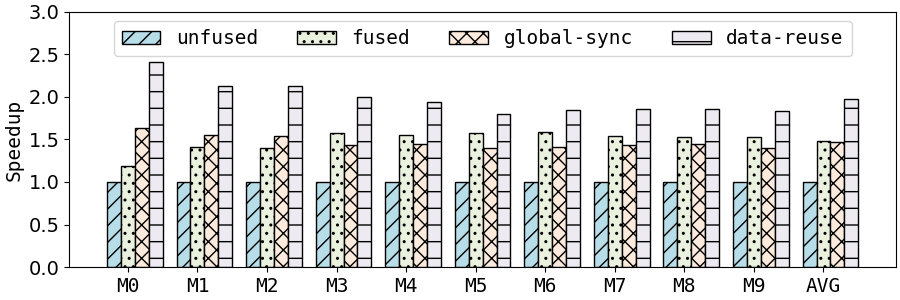

In [27]:
from IPython.display import Image
Image("results/efficientnet-se-module-latency-ours.png")

The image will be saved in `results/efficientnet-se-module-latency-ours.pdf`.
Please compare it with `Figure6`(on page 11) in the submitted paper.

## Standalone cell for unexpected result

**Latency, number of kernels and memory read bytes for ResNeXt and EfficientNet on XLA:**
Please find the "XLA RESNEXT:" and "XLA EFFICIENTNET:" at the end of the output.

In [ ]:
!docker exec -it -e SOUFFLE_RUN=TRUE $(docker ps -qf "ancestor=souffle-tvm-0.8:latest") /bin/bash -c "cd /workspace/baseline/xla/xla_models && bash run_ncu_resnext_efficientnet.sh TRUE"

## Contact
If there are any questions or suggestion, please feel free to drop me an email (scscx@leeds.ac.uk). Many thanks for your feedback!


-----
# The end of this Artifact Evaluation
-----

#### Many thanks for your review, time and efforts on this artifact evaluation.  <br> Many thanks for your understanding and bearing with some inconveniences on this notebook. 